# Identifying Significant Predictive Bias in Classifiers

In this notebook, we attempt to recreate the analysis by Zhe Zhang and Daniel Neill in [Identifying Significant Predictive Bias in Classifiers](https://arxiv.org/pdf/1611.08292.pdf).

The analysis is broken down into three steps, starting with a model trained on COMPAS decile scores only. After running bias scan, we add the distinguishing feature, priors count, to the model. We scan again and train a third model with the new subgroups accounted for. Finally, we reproduce Figure 2 from the paper.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(context='talk', style='whitegrid')

from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from aif360.sklearn.datasets import fetch_compas
from aif360.sklearn.metrics import mdss_bias_scan, mdss_bias_score

Data loading

In [2]:
cols = ['sex', 'race', 'age_cat', 'priors_count', 'c_charge_degree', 'decile_score']
X, y = fetch_compas(usecols=cols)
# Quantize priors count between 0, 1-5, and >5
X['priors_count'] = pd.cut(X['priors_count'], [-1, 0, 5, 100],
                           labels=['0', '1 to 5', 'More than 5'])
X

,,,sex,race,age_cat,priors_count,c_charge_degree,decile_score
id,sex,race,,,,,,
1,Male,Other,Male,Other,Greater than 45,0,F,1
3,Male,African-American,Male,African-American,25 - 45,0,F,3
4,Male,African-American,Male,African-American,Less than 25,1 to 5,F,4
7,Male,Other,Male,Other,25 - 45,0,M,1
8,Male,Caucasian,Male,Caucasian,25 - 45,More than 5,F,6
...,...,...,...,...,...,...,...,...
10996,Male,African-American,Male,African-American,Less than 25,0,F,7
10997,Male,African-American,Male,African-American,Less than 25,0,F,3
10999,Male,Other,Male,Other,Greater than 45,0,F,1


### 1. Decile score only

AttributeError: type object 'RocCurveDisplay' has no attribute 'from_estimator'

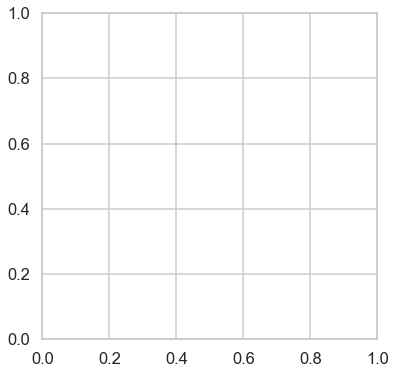

In [3]:
dec = X[['decile_score']]
northpointe = LogisticRegression(penalty='none').fit(dec, y)
y_prob = northpointe.predict_proba(dec)[:, 1]

f, ax = plt.subplots(figsize=(6, 6))
RocCurveDisplay.from_estimator(northpointe, dec, y, ax=ax);

In [4]:
df = pd.concat([X, pd.Series(1-y_prob, name='recid_prob', index=X.index)], axis=1)
orig_clf = df.groupby('decile_score').mean().recid_prob

#### Privileged group

"Privileged" in this case means the model underestimates the probability of recidivism (overestimates favorable outcomes) for this subgroup. This leads to advantage for those individuals.

In [5]:
priv_sub, priv_score = mdss_bias_scan(y, y_prob, X=X, pos_label='Survived',
                                      penalty=0.5, privileged=True)
priv = df[priv_sub.keys()].isin(priv_sub).all(axis=1)
priv_sub, priv_score

Function mdss_bias_scan is deprecated; Change to new interface - aif360.sklearn.detectors.mdss_detector.bias_scan by version 0.5.0.


({'priors_count': ['More than 5']}, 36.3302)

Note: we show probabilities of recidivism but bias scanning is done with respect to the positive label, 'Survived'.

In [6]:
print(f'Observed: {y[priv].cat.codes.mean():.2%}')
print(f'Expected: {df[priv].recid_prob.mean():.2%}')
print(f'n = {sum(priv)}')

Observed: 71.42%
Expected: 60.27%
n = 1221


#### Unprivileged group

"Unprivileged" means the model overestimates the probability of recidivism (underestimates favorable outcomes) for this subgroup. This disadvantages those individuals.

In [7]:
unpriv_sub, unpriv_score = mdss_bias_scan(y, y_prob, X=X, pos_label='Survived',
                                          penalty=0.5, privileged=False)
unpriv = df[unpriv_sub.keys()].isin(unpriv_sub).all(axis=1)
unpriv_sub, unpriv_score

({'priors_count': ['0']}, 45.1434)

In [8]:
print(f'Observed: {y[unpriv].cat.codes.mean():.2%}')
print(f'Expected: {df[unpriv].recid_prob.mean():.2%}')
print(f'n = {sum(unpriv)}')

Observed: 28.63%
Expected: 38.06%
n = 2085


### 2. Decile score + priors count

In [9]:
dec = dec.assign(priors_count=X['priors_count'].cat.codes)
northpointe = LogisticRegression(penalty='none').fit(dec, y)
y_prob_pc = northpointe.predict_proba(dec)[:, 1]

In [10]:
df = pd.concat([X, pd.Series(1-y_prob_pc, name='recid_prob', index=X.index)], axis=1)

#### Privileged group

In [11]:
priv_sub, priv_score = mdss_bias_scan(y, y_prob_pc, X=X, pos_label='Survived',
                                      penalty=1, privileged=True)
priv = df[priv_sub.keys()].isin(priv_sub).all(axis=1)
priv_sub, priv_score

Function mdss_bias_scan is deprecated; Change to new interface - aif360.sklearn.detectors.mdss_detector.bias_scan by version 0.5.0.


({'sex': ['Male'], 'age_cat': ['Less than 25']}, 24.49)

In [12]:
print(f'Observed: {y[priv].cat.codes.mean():.2%}')
print(f'Expected: {df[priv].recid_prob.mean():.2%}')
print(f'n = {sum(priv)}')

priv_unpen = mdss_bias_score(y, y_prob_pc, X=X, subset=priv_sub,
                             pos_label='Survived', privileged=True, penalty=0)
print(f'unpenalized score: {priv_unpen:.2f}')

Observed: 60.04%
Expected: 49.76%
n = 1101
unpenalized score: 26.49


#### Unprivileged group

In [13]:
unpriv_sub, unpriv_score = mdss_bias_scan(y, y_prob_pc, X=X, pos_label='Survived',
                                          penalty=0.25, privileged=False, n_iter=25)
unpriv = df[unpriv_sub.keys()].isin(unpriv_sub).all(axis=1)
unpriv_sub, unpriv_score

({'decile_score': [2, 3, 6, 9, 10],
  'sex': ['Female'],
  'c_charge_degree': ['M']},
 12.1591)

In [14]:
print(f'Observed: {y[unpriv].cat.codes.mean():.2%}')
print(f'Expected: {df[unpriv].recid_prob.mean():.2%}')
print(f'n = {sum(unpriv)}')

unpriv_unpen = mdss_bias_score(y, y_prob_pc, X=X, subset=unpriv_sub,
                               pos_label='Survived', privileged=False, penalty=0)
print(f'unpenalized score: {unpriv_unpen:.2f}')

Observed: 20.79%
Expected: 36.96%
n = 202
unpenalized score: 13.91


### 3. Decile score + priors count + top groups

In [15]:
df['group'] = 'neither'
df.loc[priv, 'group'] = 'under-estimated'
df.loc[unpriv, 'group'] = 'over-estimated'
df['group'] = df.group.astype('category')
df.head()

,,,sex,race,age_cat,priors_count,c_charge_degree,decile_score,recid_prob,group
id,sex,race,,,,,,,,
1,Male,Other,Male,Other,Greater than 45,0,F,1,0.186358,neither
3,Male,African-American,Male,African-American,25 - 45,0,F,3,0.265247,neither
4,Male,African-American,Male,African-American,Less than 25,1 to 5,F,4,0.448002,under-estimated
7,Male,Other,Male,Other,25 - 45,0,M,1,0.186358,neither
8,Male,Caucasian,Male,Caucasian,25 - 45,More than 5,F,6,0.696115,neither


In [16]:
dec = dec.join(pd.get_dummies(df.group))
northpointe = LogisticRegression(penalty='none').fit(dec, y)
y_prob_pcg = northpointe.predict_proba(dec)[:, 1]
df['recid_prob'] = 1 - y_prob_pcg

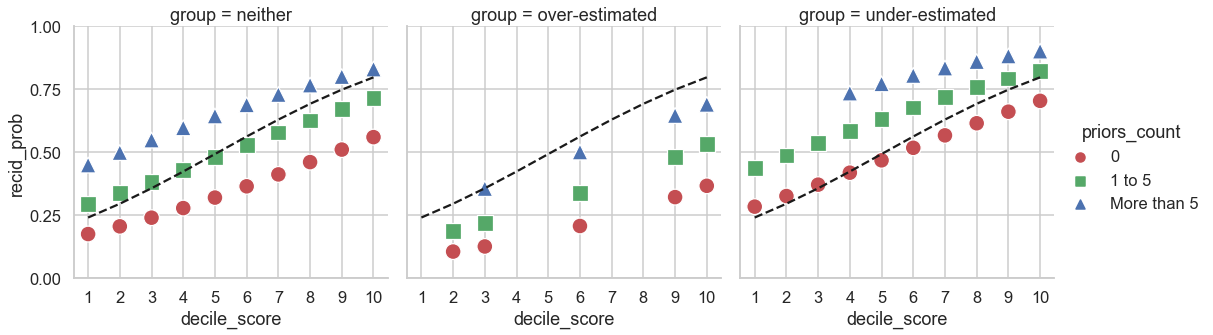

In [17]:
p = sns.relplot(data=df.groupby(['decile_score', 'priors_count', 'group']).mean(),
                x='decile_score', y='recid_prob', hue='priors_count',
                style='priors_count', palette=['r', 'g', 'b'],
                markers=['o', 's', '^'], col='group', s=250)
for ax in p.axes.flatten():
    ax.plot(range(1, 11), orig_clf, '--k')
plt.ylim([0, 1]);
plt.yticks(np.linspace(0, 1., 5));
plt.xticks(range(1, 11));